In [28]:
import pandas as pd
import ta
import numpy as np
import pickle
import itertools
from datetime import datetime

from alphalens import utils, plotting, performance, tears

import mlfinlab as ml

from utilities import (
    getIndicator, 
    getForwardReturns, getCleanFactor, addGroupingFactor,
    plotFactorQuantileBars, plotCumulativeReturns, plotQuantileCumulativeReturns,
    InformationTable)

from factor_library import trend, volume, volatility, momentum

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

import pyfolio

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
cusumTrainPrices = pickle.load(open('/home/ubuntu/projects/trading/data/cusumTrainPrices.pkl', 'rb'))
target = pickle.load(open('/home/ubuntu/projects/trading/data/binary_target_5_day.pkl', 'rb'))

In [3]:
cusumTrainPrices['WHL.JO']

,high,low,open,close,volume,adj_close,event,vertical_barriers,t1,expected_return,label,profit_taking,stop_loss,holding_period
date,,,,,,,,,,,,,,
2013-01-01,6760.160156,6760.160156,6760.160156,6760.160156,0.0,5069.762207,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2013-01-02,6895.359863,6586.870117,6854.419922,6679.229980,2105298.0,5009.068848,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2013-01-03,6855.370117,6712.549805,6759.209961,6741.120117,3103630.0,5055.483887,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2013-01-04,6878.220215,6707.790039,6735.399902,6878.220215,2293156.0,5158.302246,1,2013-01-09,2013-01-07,-0.010381,-1.0,0.000002,-0.000002,3.0
2013-01-07,6902.979980,6769.680176,6879.180176,6781.109863,1809340.0,5085.473145,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,6326.000000,6222.000000,6283.000000,6293.000000,1920416.0,5665.954102,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2017-12-25,6293.000000,6293.000000,6293.000000,6293.000000,0.0,5665.954102,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2017-12-26,6293.000000,6293.000000,6293.000000,6293.000000,0.0,5665.954102,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [4]:
for symbol, data in cusumTrainPrices.items():
    
    data = data[data['event'] == 1]
    cusumTrainPrices[symbol] = data

In [5]:
forward_returns = getForwardReturns(datas = cusumTrainPrices)
forward_returns

1D  event         t1
date       asset                             
2013-01-04 ACT.JO -0.038855      1 2013-01-07
           AEE.JO -0.062500      1 2013-01-07
           AFE.JO  0.060550      1 2013-01-07
           AFT.JO  0.069900      1 2013-01-07
           AFX.JO  0.021739      1 2013-01-07
...                     ...    ...        ...
2017-12-27 TMT.JO       NaN      1 2017-12-28
           TON.JO       NaN      1 2017-12-28
           TRU.JO       NaN      1 2017-12-28
           TWR.JO       NaN      1 2017-12-28
           WBO.JO       NaN      1 2017-12-28

[89920 rows x 3 columns]

In [6]:
trailing_volume_window = 20

In [7]:
macd_data = getIndicator(
    cusumTrainPrices,
    trend.macdDiff, n_slow = 6, n_fast = 4, n_sign = 3,
    trailing_volume_n = trailing_volume_window
)
macd_data = macd_data.unstack().asfreq('C').stack()
macd_data

MACD_diff_4_6
date       symbol               
2013-02-18 HLM.JO      -1.792190
2013-02-19 HLM.JO      -2.603653
2013-02-21 HLM.JO      -3.440057
2013-02-25 HLM.JO      -2.084177
2013-02-27 HLM.JO      -4.604300
...                          ...
2017-12-29 TDH.JO       1.523570
           TKG.JO      14.465021
           TRU.JO      -1.327323
           VOD.JO      16.719320
           ZED.JO       2.574282

[58323 rows x 1 columns]

In [8]:
macd_factor_data = getCleanFactor(macd_data, forward_returns, quantiles = 10)
macd_factor_data

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,,1D,factor,factor_quantile
date,asset,,,
2013-04-15,ACT.JO,0.014118,-2.398241,7.0
2013-04-16,ACT.JO,0.000000,-0.399138,7.0
2013-04-18,ACT.JO,0.044084,-0.641828,8.0
2013-04-19,ACT.JO,-0.011111,1.040696,5.0
2013-04-30,ACT.JO,-0.033708,1.756575,4.0
...,...,...,...,...
2017-12-14,STXWDM.JO,-0.030055,-2.004452,5.0
2017-12-15,STXWDM.JO,-0.008451,-3.759333,3.0
2017-12-18,STXWDM.JO,-0.025284,-5.420287,2.0


In [9]:
InformationTable(macd_factor_data)

Information Analysis


,1D
IC Mean,0.001
IC Std.,0.184
Risk-Adjusted IC,0.005
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


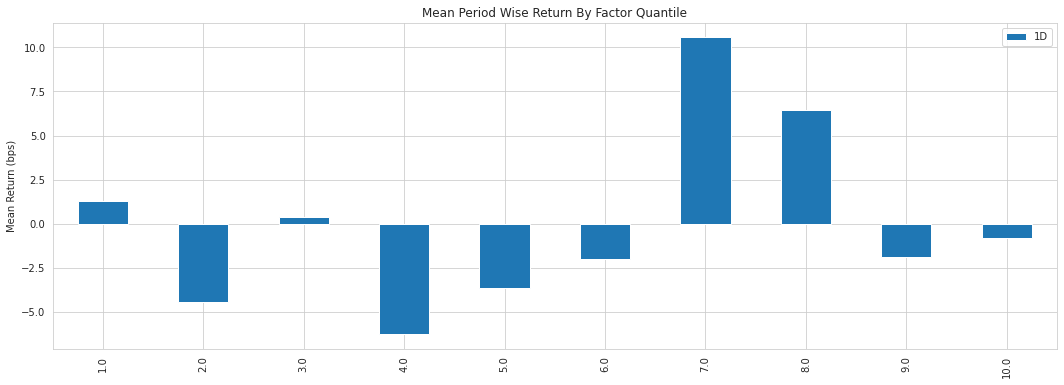

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

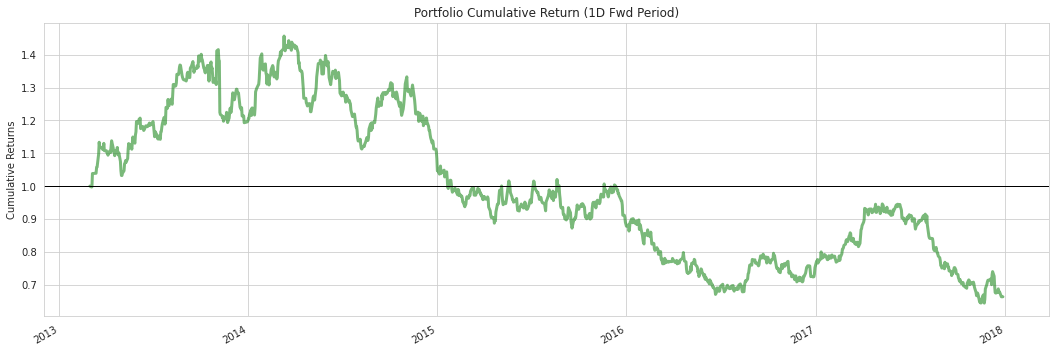

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

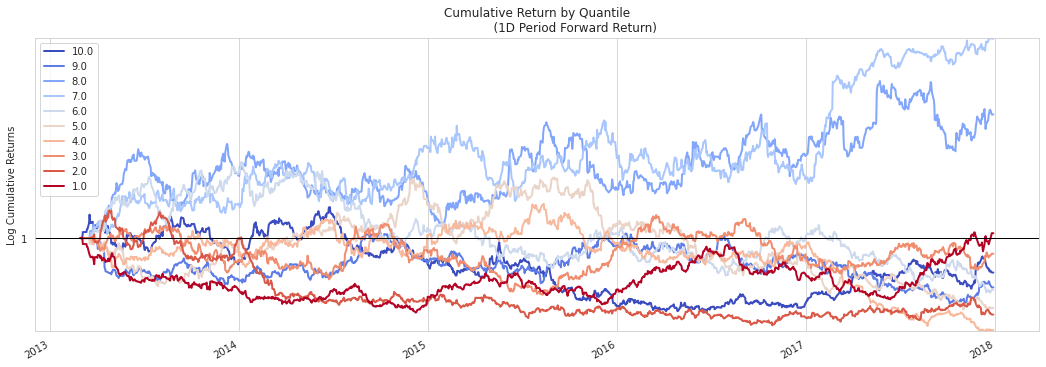

In [10]:
plotFactorQuantileBars(macd_factor_data)

plotCumulativeReturns(macd_factor_data[macd_factor_data['factor_quantile'].isin([1, 10])])

plotQuantileCumulativeReturns(macd_factor_data)

In [11]:
volume_osc_data = getIndicator(
    cusumTrainPrices, 
    volume.getVolumeOsc, periods = 10, 
    trailing_volume_n = trailing_volume_window)
volume_osc_data

,,volume_oscillator20
date,symbol,
2013-04-26,ABG.JO,1.861227e+06
2013-04-30,ABG.JO,2.322066e+06
2013-05-09,ABG.JO,2.418655e+06
2013-05-16,ABG.JO,2.251685e+06
2013-05-20,ABG.JO,2.506510e+06
...,...,...
2017-12-04,ZPLP.JO,1.832404e+05
2017-12-07,ZPLP.JO,1.838065e+05
2017-12-14,ZPLP.JO,1.665370e+05


In [12]:
volume_factor_data = getCleanFactor(volume_osc_data, forward_returns, quantiles = 4)
volume_factor_data

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,,1D,factor,factor_quantile
date,asset,,,
2013-04-15,ACT.JO,0.014118,171914.176063,1.0
2013-04-16,ACT.JO,0.000000,155763.053142,1.0
2013-04-18,ACT.JO,0.044084,138183.588935,1.0
2013-04-19,ACT.JO,-0.011111,123112.936401,1.0
2013-04-30,ACT.JO,-0.033708,130637.857055,1.0
...,...,...,...,...
2017-12-14,STXWDM.JO,-0.030055,80947.290202,1.0
2017-12-15,STXWDM.JO,-0.008451,78728.873802,1.0
2017-12-18,STXWDM.JO,-0.025284,87193.624020,1.0


In [13]:
InformationTable(volume_factor_data)

Information Analysis


,1D
IC Mean,0.010
IC Std.,0.186
Risk-Adjusted IC,0.054
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


In [14]:
if 'group' not in macd_factor_data.columns:
    macd_factor_data = addGroupingFactor(macd_factor_data, volume_factor_data)
else:
    macd_factor_data.drop('group', axis = 1, inplace = True)
    macd_factor_data = addGroupingFactor(macd_factor_data, volume_factor_data)
macd_factor_data

,,1D,factor,factor_quantile,group
date,asset,,,,
2013-04-15,ACT.JO,0.014118,-2.398241,7.0,1.0
2013-04-16,ACT.JO,0.000000,-0.399138,7.0,1.0
2013-04-18,ACT.JO,0.044084,-0.641828,8.0,1.0
2013-04-19,ACT.JO,-0.011111,1.040696,5.0,1.0
2013-04-30,ACT.JO,-0.033708,1.756575,4.0,1.0
...,...,...,...,...,...
2017-12-14,STXWDM.JO,-0.030055,-2.004452,5.0,1.0
2017-12-15,STXWDM.JO,-0.008451,-3.759333,3.0,1.0
2017-12-18,STXWDM.JO,-0.025284,-5.420287,2.0,1.0


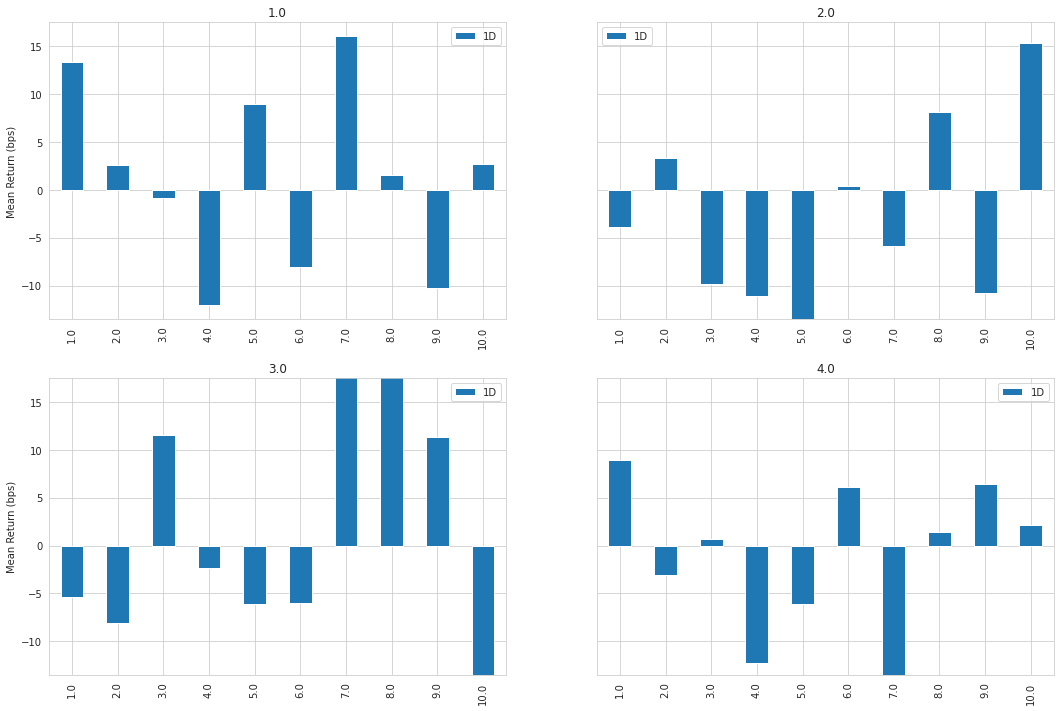

In [15]:
plotFactorQuantileBars(macd_factor_data, by_group = True, group_adjust = False)

In [16]:
obv_data = getIndicator(
    cusumTrainPrices, 
    volume.obv,
    trailing_volume_n = trailing_volume_window)
obv_factor_data = getCleanFactor(obv_data, forward_returns, quantiles = 10)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


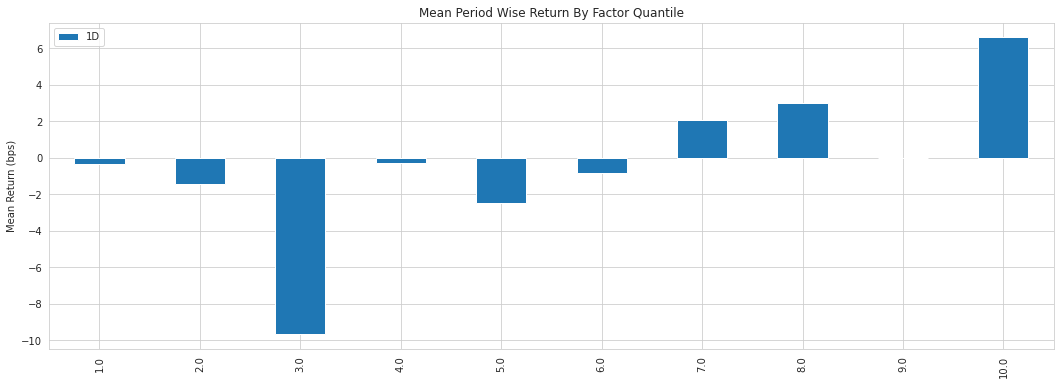

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

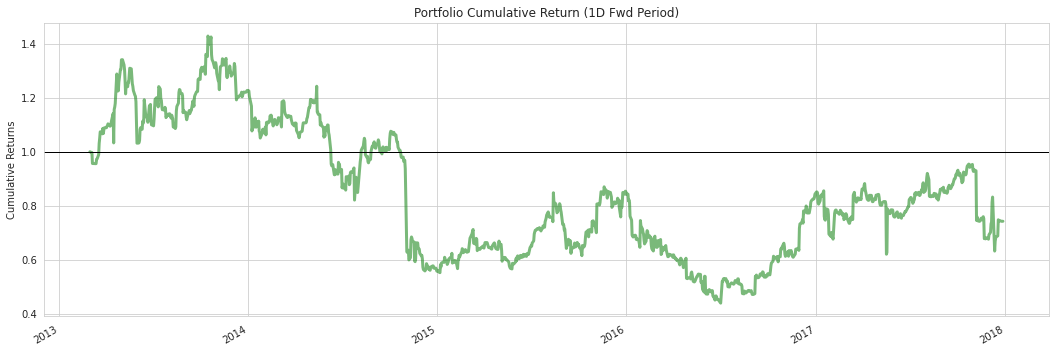

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

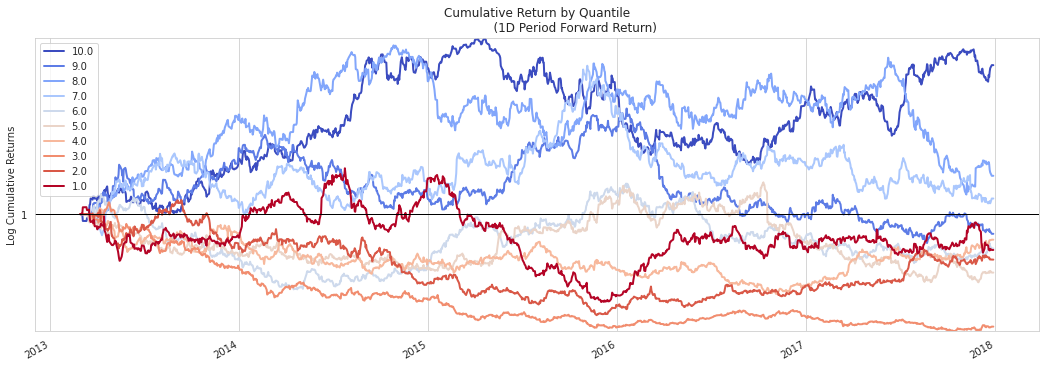

In [17]:
plotFactorQuantileBars(obv_factor_data)

plotCumulativeReturns(obv_factor_data[obv_factor_data['factor_quantile'].isin([1, 10])])

plotQuantileCumulativeReturns(obv_factor_data)

In [18]:
dc_data = getIndicator(
    cusumTrainPrices, 
    volatility.dc, n = 20,
    trailing_volume_n = trailing_volume_window)
dc_factor_data = getCleanFactor(dc_data, forward_returns, quantiles = 3)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


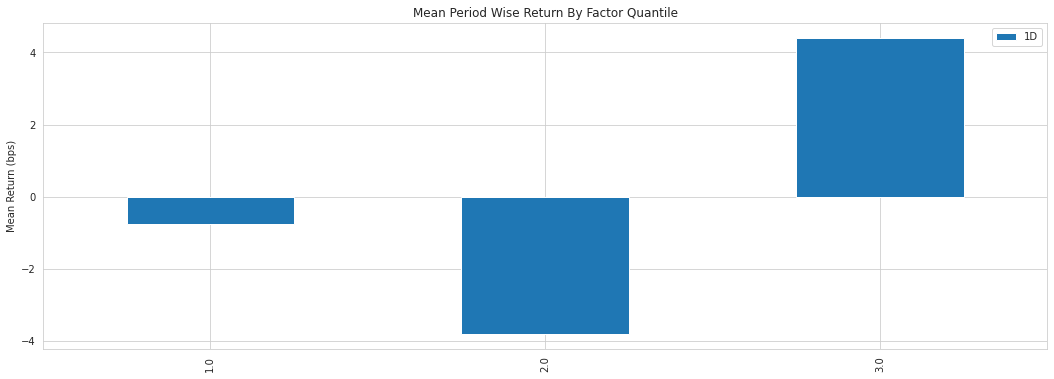

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

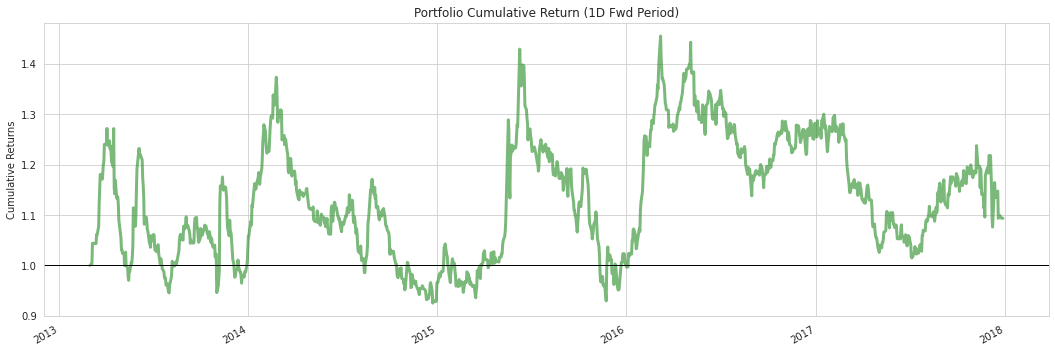

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

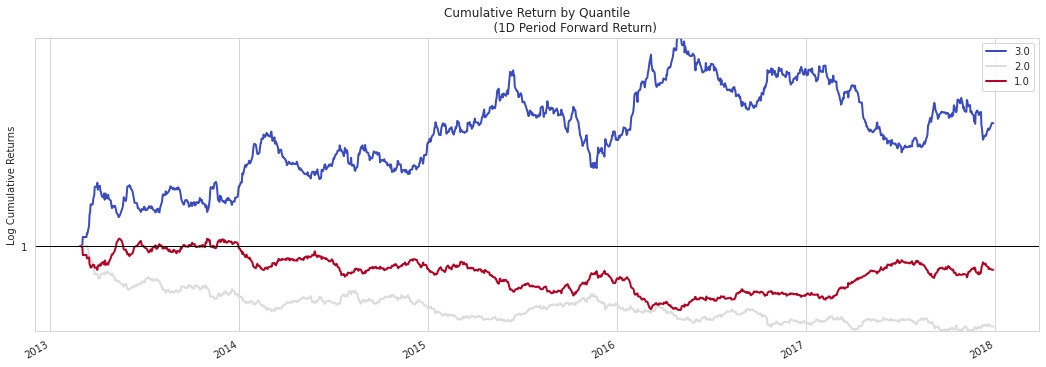

In [19]:
plotFactorQuantileBars(dc_factor_data)

plotCumulativeReturns(dc_factor_data[dc_factor_data['factor_quantile'].isin([1, 3])])

plotQuantileCumulativeReturns(dc_factor_data)

In [20]:
wr_data = getIndicator(
    cusumTrainPrices, 
    momentum.williamsR, lbp = 50,
    trailing_volume_n = trailing_volume_window) 
wr_factor_data = getCleanFactor(wr_data, forward_returns, quantiles = 5)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


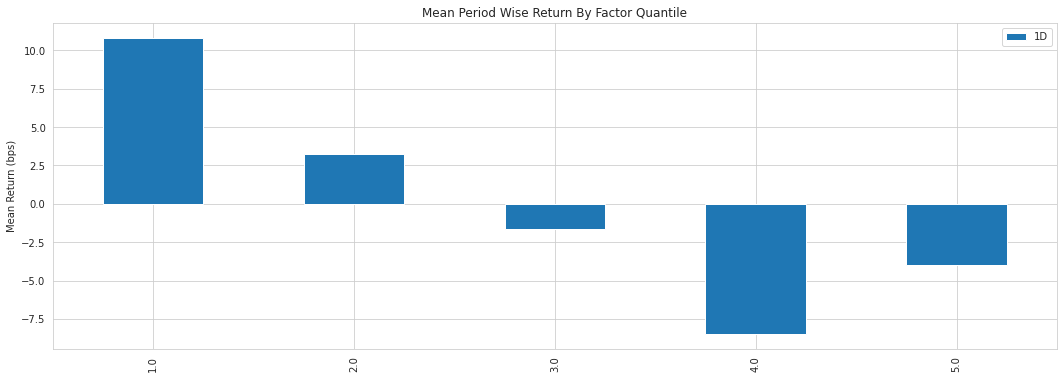

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

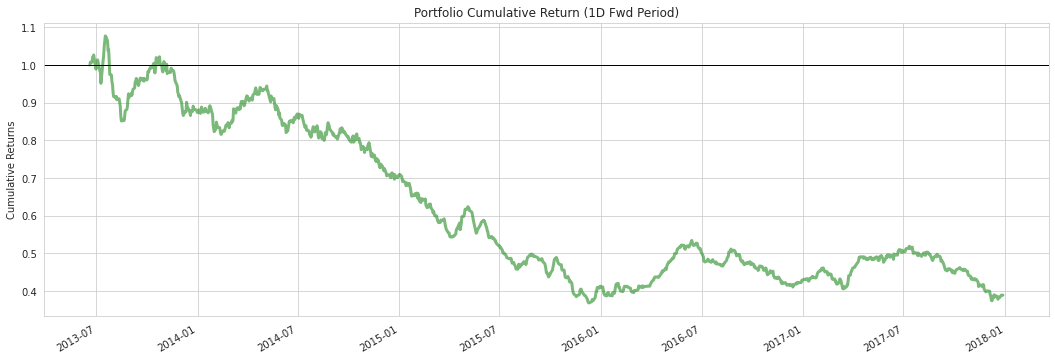

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

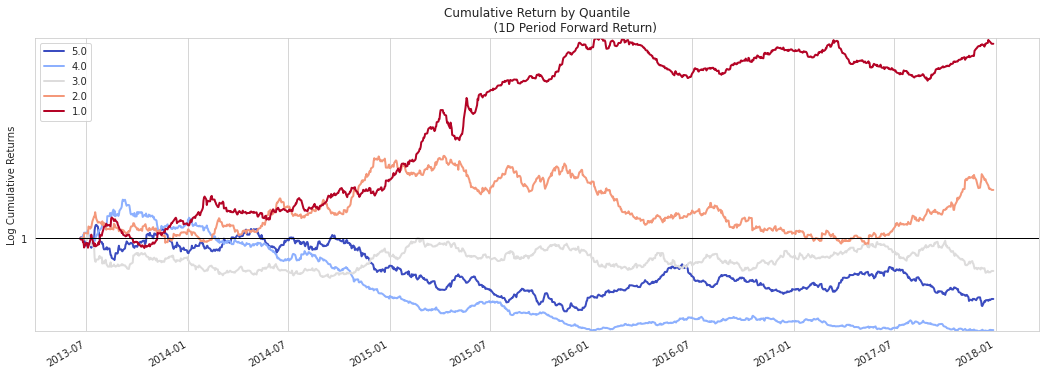

In [21]:
plotFactorQuantileBars(wr_factor_data)

plotCumulativeReturns(wr_factor_data[wr_factor_data['factor_quantile'].isin([1, 5])])

plotQuantileCumulativeReturns(wr_factor_data)

In [22]:
mfi_data = getIndicator(
    cusumTrainPrices, 
    volume.mfi, n = 5,
    trailing_volume_n = trailing_volume_window) 
mfi_factor_data = getCleanFactor(mfi_data, forward_returns, quantiles = 2)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


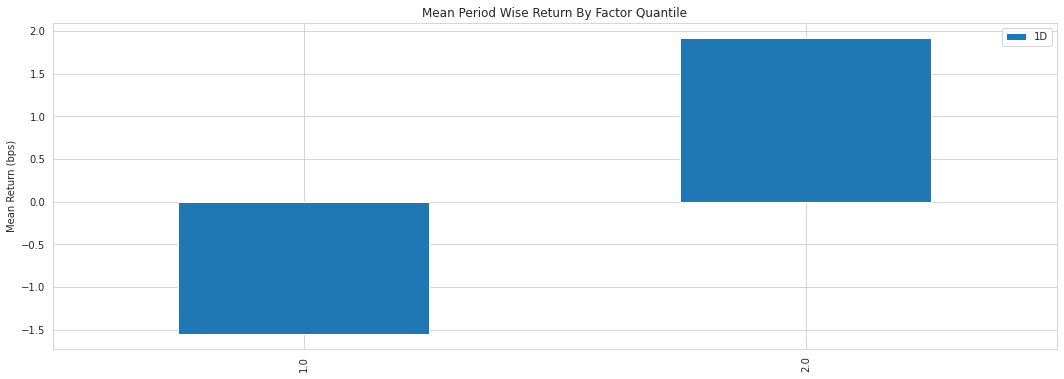

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

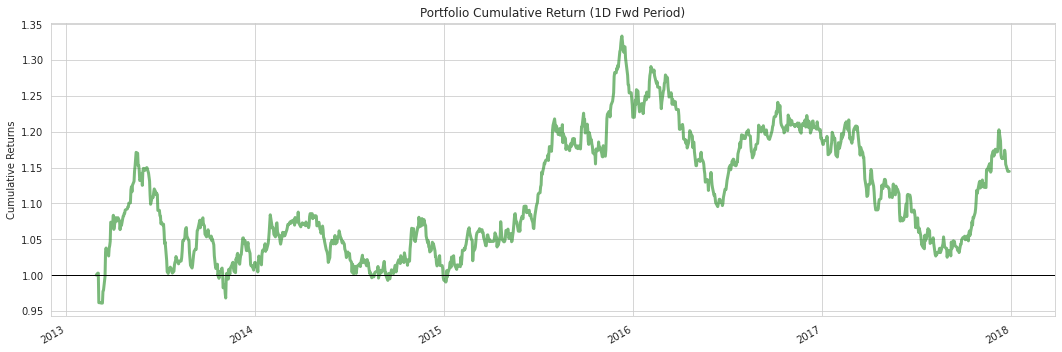

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

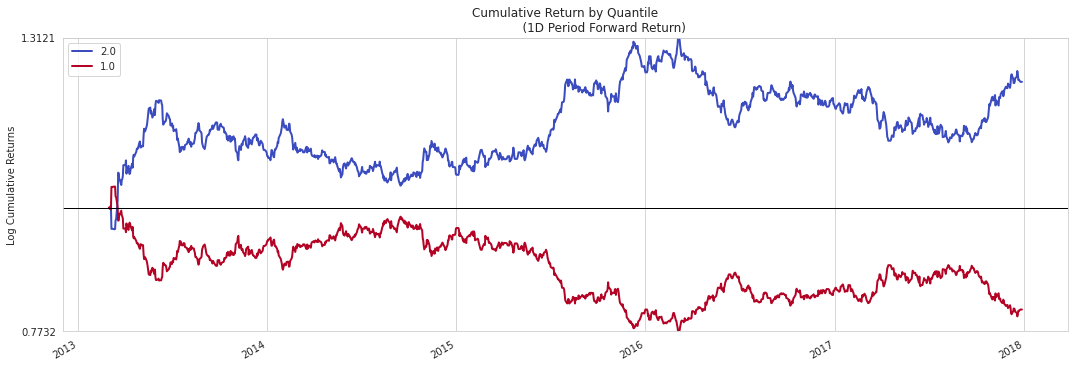

In [23]:
plotFactorQuantileBars(mfi_factor_data)

plotCumulativeReturns(mfi_factor_data[mfi_factor_data['factor_quantile'].isin([1, 2])])

plotQuantileCumulativeReturns(mfi_factor_data)

In [103]:
train = pd.concat([
           macd_factor_data['factor_quantile'], 
           volume_factor_data['factor_quantile'],
           obv_factor_data['factor_quantile'],
           dc_factor_data['factor_quantile'],
           wr_factor_data['factor_quantile'],
           mfi_factor_data['factor_quantile'],
           target[['label']]
    ], axis = 1).dropna()
train

factor_quantile  group  factor_quantile  factor_quantile  \
date       asset                                                              
2013-06-20 GRT.JO              4.0    4.0              1.0              3.0   
           RLO.JO             10.0    2.0              4.0              3.0   
2013-06-24 GRT.JO              6.0    4.0              1.0              3.0   
           RLO.JO             10.0    2.0              4.0              3.0   
           SPG.JO              8.0    2.0              9.0              2.0   
...                            ...    ...              ...              ...   
2017-12-22 TWR.JO              6.0    1.0              4.0              1.0   
           WBO.JO             10.0    2.0              6.0              1.0   
2017-12-27 CTA.JO              1.0    4.0             10.0              2.0   
           MCZ.JO             10.0    1.0              5.0              3.0   
           RBP.JO              5.0    2.0              1.0              1.0   

                   factor_quantile  factor_quantile  label  
date       asset                                            
2013-06-20 GRT.JO              5.0              1.0   -1.0  
           RLO.JO              1.0              2.0   -1.0  
2013-06-24 GRT.JO              5.0              2.0    1.0  
           RLO.JO              4.0              2.0   -1.0  
           SPG.JO              1.0              1.0    1.0  
...                            ...              ...    ...  
2017-12-22 TWR.JO              5.0              1.0    1.0  
           WBO.JO              1.0              2.0   -1.0  
2017-12-27 CTA.JO              1.0              1.0   -1.0  
           MCZ.JO              3.0              1.0    1.0  
           RBP.JO              5.0              2.0   -1.0  

[59222 rows x 7 columns]

In [104]:
X = train.iloc[:, :-1]
X.columns = ['macd', 'volume', 'obv', 'dc', 'wr', 'mfi']
y = train['label']

In [155]:
def checkCV(X, cv, max_train_size):
    ts = TimeSeriesSplit(n_splits = cv, max_train_size = max_train_size)
    for i, (train_index, test_index) in enumerate(ts.split(X.unstack())):
        
        if len(X.unstack().iloc[train_index, ]) >= max_train_size:
            print(f"Fold {i + 1} -------------------------------------------------------")
            print(f"Train: Length = {len(X.unstack().iloc[train_index, ].index)}")
            print(f"Start date: {X.unstack().iloc[train_index, ].index[0].date()}")
            print(f"End date: {X.unstack().iloc[train_index, ].index[-1].date()} \n")

            print(f"Test: Length =  {len(X.unstack().iloc[test_index, ].index)}")
            print(f"Start date: {X.unstack().iloc[test_index, ].index[0].date()}")
            print(f"End date: {X.unstack().iloc[test_index, ].index[-1].date()}")
            print(f"----------------------------------------------------------------")

checkCV(X, 12, max_train_size = 252)

Fold 3 -------------------------------------------------------
Train: Length = 252
Start date: 2013-07-17
End date: 2014-07-22 

Test: Length =  86
Start date: 2014-07-23
End date: 2014-11-20
----------------------------------------------------------------
Fold 4 -------------------------------------------------------
Train: Length = 252
Start date: 2013-11-18
End date: 2014-11-20 

Test: Length =  86
Start date: 2014-11-21
End date: 2015-03-26
----------------------------------------------------------------
Fold 5 -------------------------------------------------------
Train: Length = 252
Start date: 2014-03-25
End date: 2015-03-26 

Test: Length =  86
Start date: 2015-03-27
End date: 2015-07-31
----------------------------------------------------------------
Fold 6 -------------------------------------------------------
Train: Length = 252
Start date: 2014-07-31
End date: 2015-07-31 

Test: Length =  86
Start date: 2015-08-03
End date: 2015-12-02
-------------------------------------

In [106]:
def modelFit(clf, X, y, cv, max_train_size):

    predictions = pd.DataFrame()
    probabilities = pd.DataFrame()
    ts = TimeSeriesSplit(n_splits = cv, max_train_size=max_train_size) # 
    for train_index, test_index in ts.split(X.unstack()):

        
        train_X = X.unstack().iloc[train_index, ].stack()
        train_y = y.unstack().iloc[train_index].stack()

        test_X = X.unstack().iloc[test_index, ].stack()
        test_y = y.unstack().iloc[test_index].stack()
        
        if len(train_X.unstack()) >= max_train_size:
            model = clf
            model.fit(
                train_X, 
                train_y)

            cal_model = CalibratedClassifierCV(model, cv = 'prefit')
            cal_model.fit(train_X, train_y)

            probs = pd.DataFrame(
                cal_model.predict_proba(test_X), 
                columns = cal_model.classes_, 
                index = test_X.index)

            probabilities = pd.concat(
                [probabilities, probs])

            preds = pd.DataFrame(
                model.predict(test_X), 
                columns = ['predictions'], 
                index = test_X.index)
            preds['actual'] = test_y

            predictions = pd.concat(
                [predictions, preds])
    #         print('DONE!!!!!!!!!!!!!!!!!!!!!')
    return predictions, probabilities

In [156]:
clf = LogisticRegression(random_state = 42)
predictions, probabilities = modelFit(clf, X, y, cv = 12, max_train_size = 252)

In [157]:
probs = probabilities.loc[:, 1] * -1
probs.name = 'factor'
factor = pd.DataFrame(probs) 
factor.index.set_names(['date', 'symbol'], inplace = True)
factor

factor
date       symbol          
2014-07-23 ACL.JO -0.518133
           ADH.JO -0.528961
           AFE.JO -0.510152
           AFT.JO -0.501589
           AVV.JO -0.521557
...                     ...
2017-12-22 TWR.JO -0.508470
           WBO.JO -0.495830
2017-12-27 CTA.JO -0.484151
           MCZ.JO -0.517240
           RBP.JO -0.492493

[51373 rows x 1 columns]

In [158]:
clf_factor_data = getCleanFactor(factor, forward_returns, quantiles = 10)
clf_factor_data

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,,1D,factor,factor_quantile
date,asset,,,
2014-08-08,ACT.JO,-0.022222,-0.507667,8.0
2014-08-12,ACT.JO,-0.011364,-0.521104,5.0
2014-08-13,ACT.JO,-0.011494,-0.519400,5.0
2014-08-20,ACT.JO,0.011628,-0.519356,5.0
2014-08-21,ACT.JO,-0.045977,-0.514262,7.0
...,...,...,...,...
2017-11-21,L2D.JO,-0.025000,-0.501372,4.0
2017-11-23,L2D.JO,-0.004884,-0.487300,10.0
2017-11-24,L2D.JO,0.006135,-0.501372,3.0


In [159]:
InformationTable(clf_factor_data)

Information Analysis


,1D
IC Mean,0.024
IC Std.,0.159
Risk-Adjusted IC,0.151
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


In [160]:
performance.factor_alpha_beta(clf_factor_data)

,1D
Ann. alpha,0.248268
beta,-0.098342


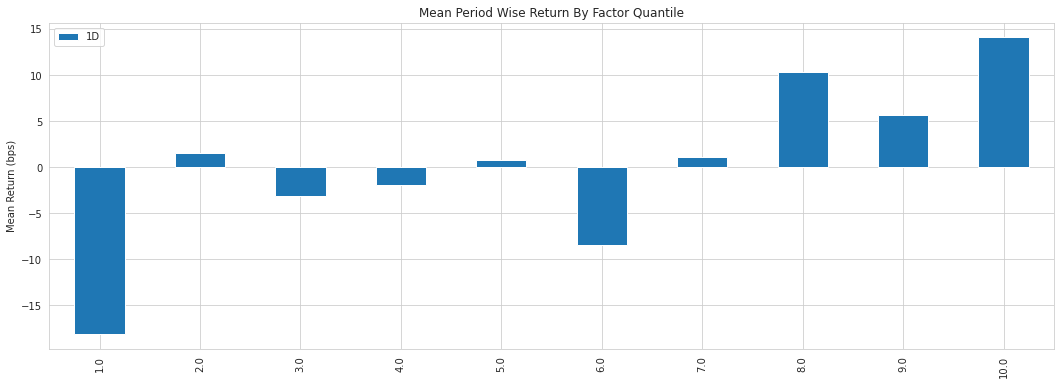

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

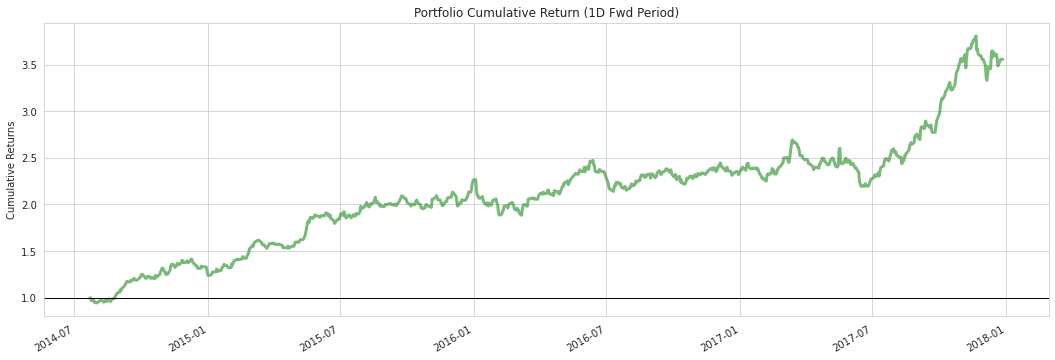

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

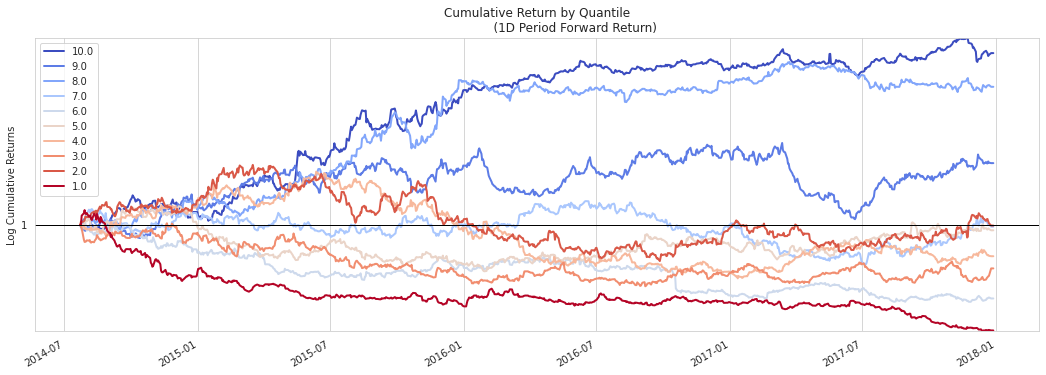

In [161]:
plotFactorQuantileBars(clf_factor_data)

plotCumulativeReturns(clf_factor_data[clf_factor_data['factor_quantile'].isin([1, 10])])

plotQuantileCumulativeReturns(clf_factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.550385,-0.504015,-0.521757,0.010998,5531,10.766356
2.0,-0.542302,-0.501169,-0.515585,0.009337,5087,9.902089
3.0,-0.534847,-0.498752,-0.512007,0.008698,5010,9.752204
4.0,-0.529302,-0.496369,-0.508860,0.008245,5108,9.942966
5.0,-0.525738,-0.492493,-0.505872,0.007739,5165,10.053919
6.0,-0.520753,-0.490137,-0.502954,0.007118,4919,9.575069
7.0,-0.518447,-0.486993,-0.500061,0.006640,5014,9.759991
8.0,-0.513543,-0.482531,-0.496924,0.006312,5100,9.927394
9.0,-0.510233,-0.476194,-0.493250,0.006066,5000,9.732739


Returns Analysis


,1D
Ann. alpha,0.248
beta,-0.098
Mean Period Wise Return Top Quantile (bps),14.070
Mean Period Wise Return Bottom Quantile (bps),-18.083
Mean Period Wise Spread (bps),32.153


/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 432x288 with 0 Axes>

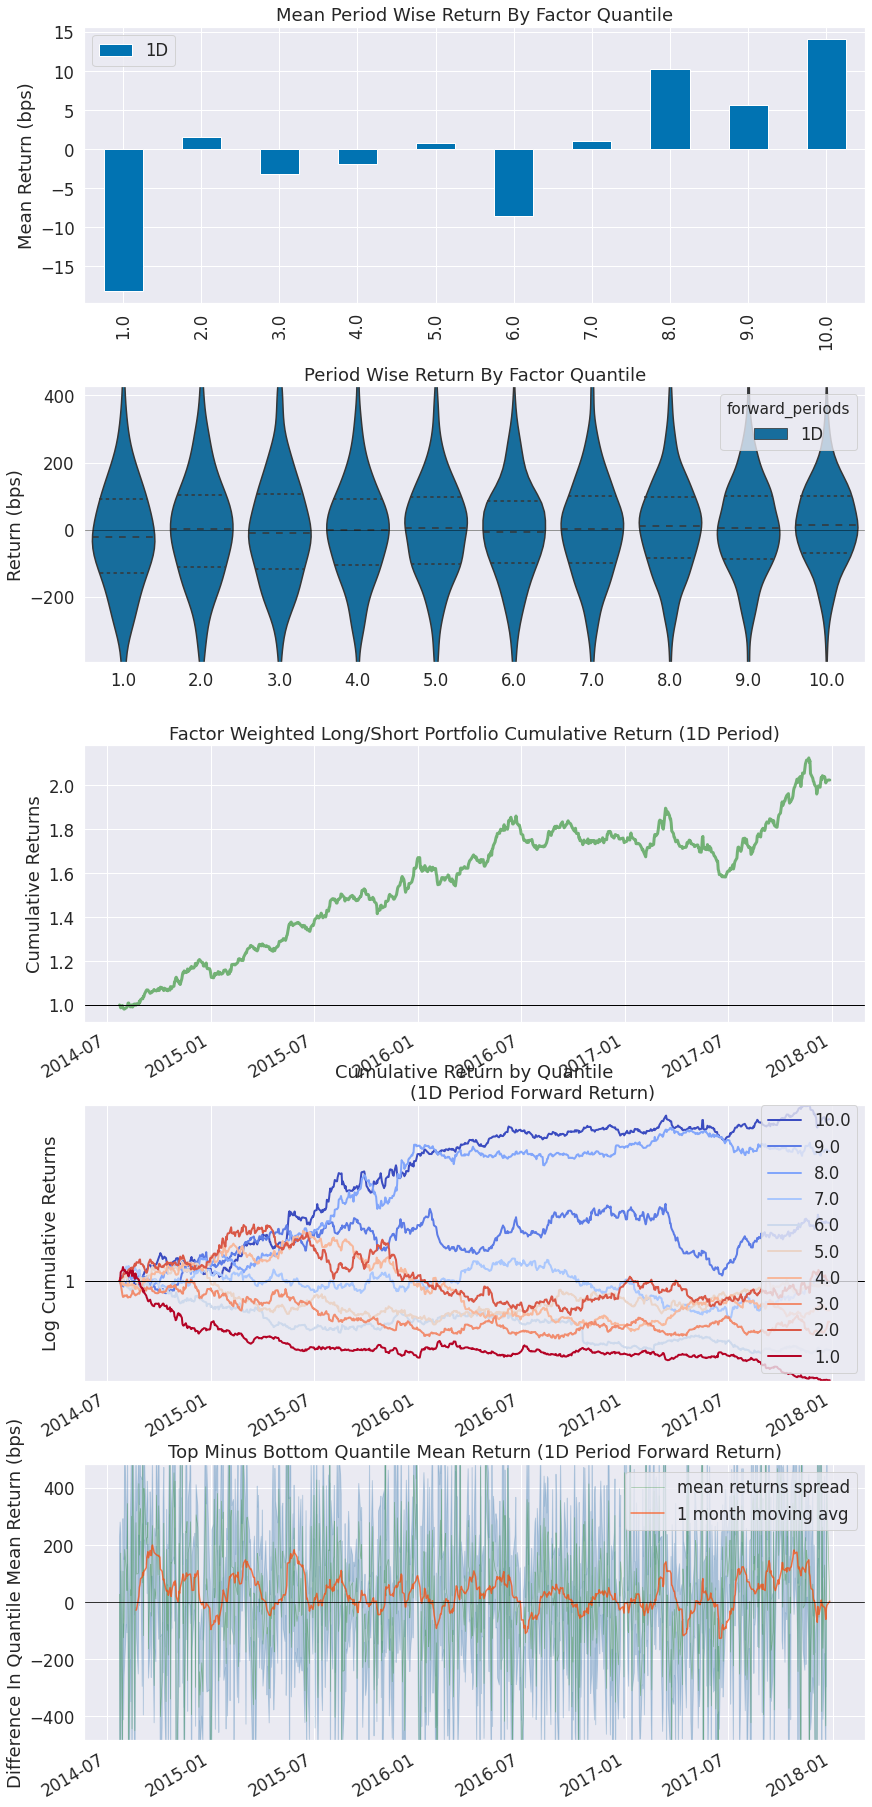

Information Analysis


,1D
IC Mean,0.024
IC Std.,0.159
Risk-Adjusted IC,0.151
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


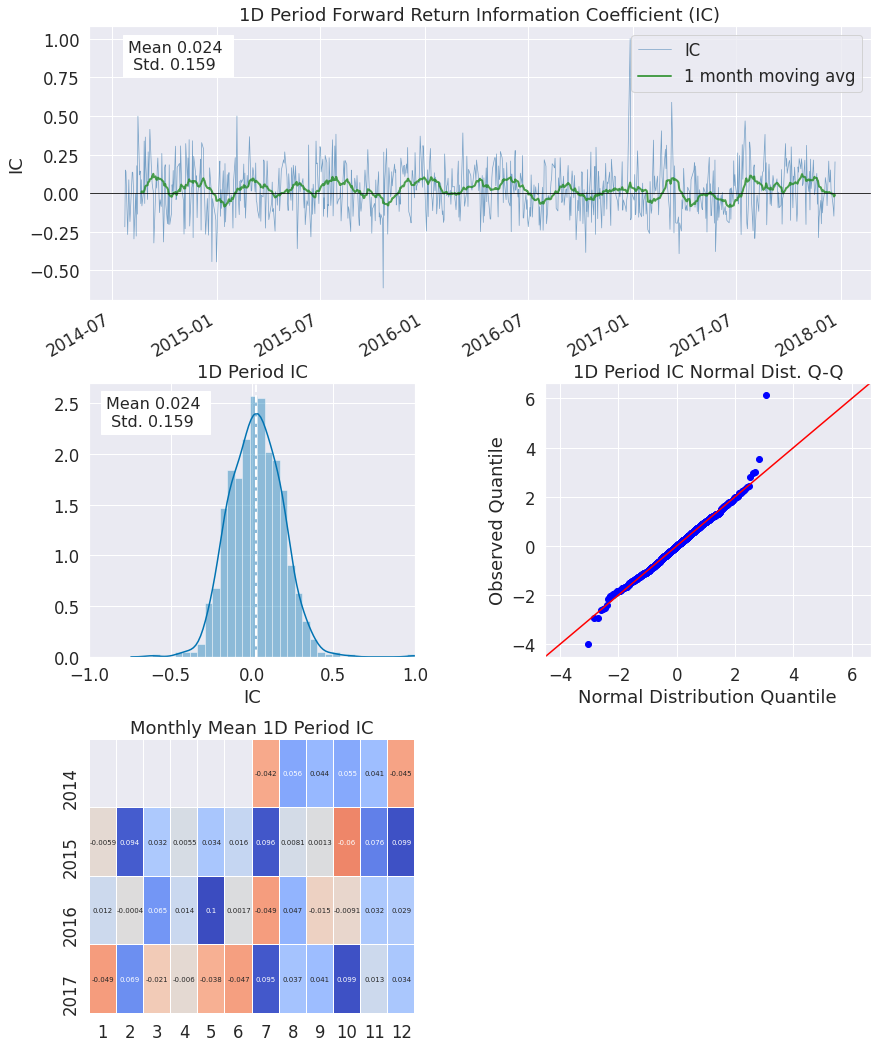

Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.861
Quantile 2 Mean Turnover,0.918
Quantile 3 Mean Turnover,0.941
Quantile 4 Mean Turnover,0.949
Quantile 5 Mean Turnover,0.944
Quantile 6 Mean Turnover,0.950
Quantile 7 Mean Turnover,0.948
Quantile 8 Mean Turnover,0.937
Quantile 9 Mean Turnover,0.935
Quantile 10 Mean Turnover,0.878


,1D
Mean Factor Rank Autocorrelation,0.762


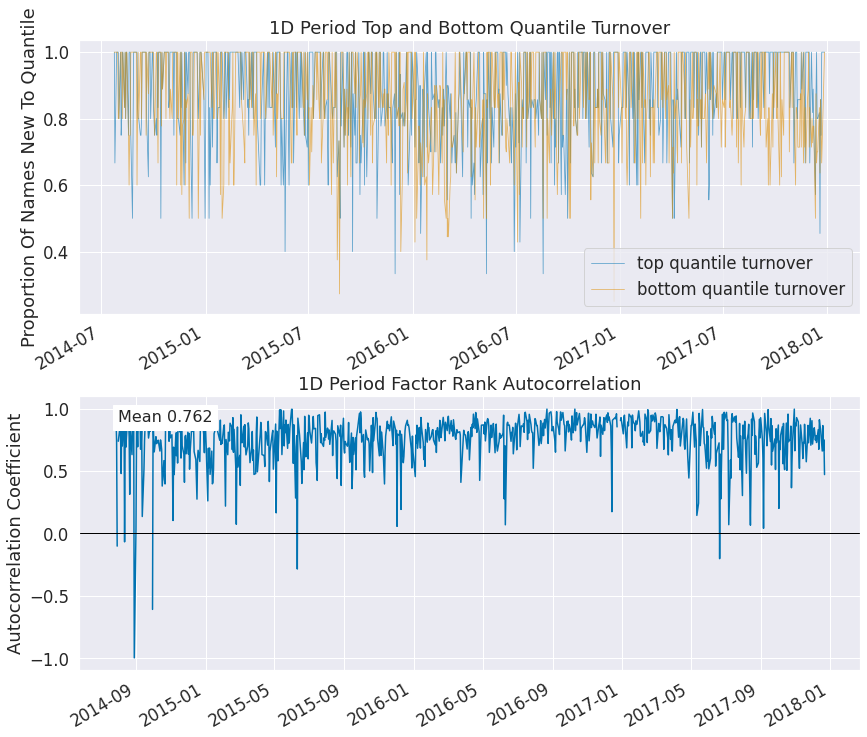

In [162]:
tears.create_full_tear_sheet(clf_factor_data)

In [175]:
returns, positions, benchmark = performance.create_pyfolio_input(clf_factor_data, quantiles = [1, 10], period = '1D')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:545: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


Start date,2014-07-23
End date,2017-12-28
Total months,59
,Backtest
Annual return,29.0%
Cumulative returns,255.6%
Annual volatility,17.1%
Sharpe ratio,1.57
Calmar ratio,1.57
Stability,0.86
Max drawdown,-18.4%


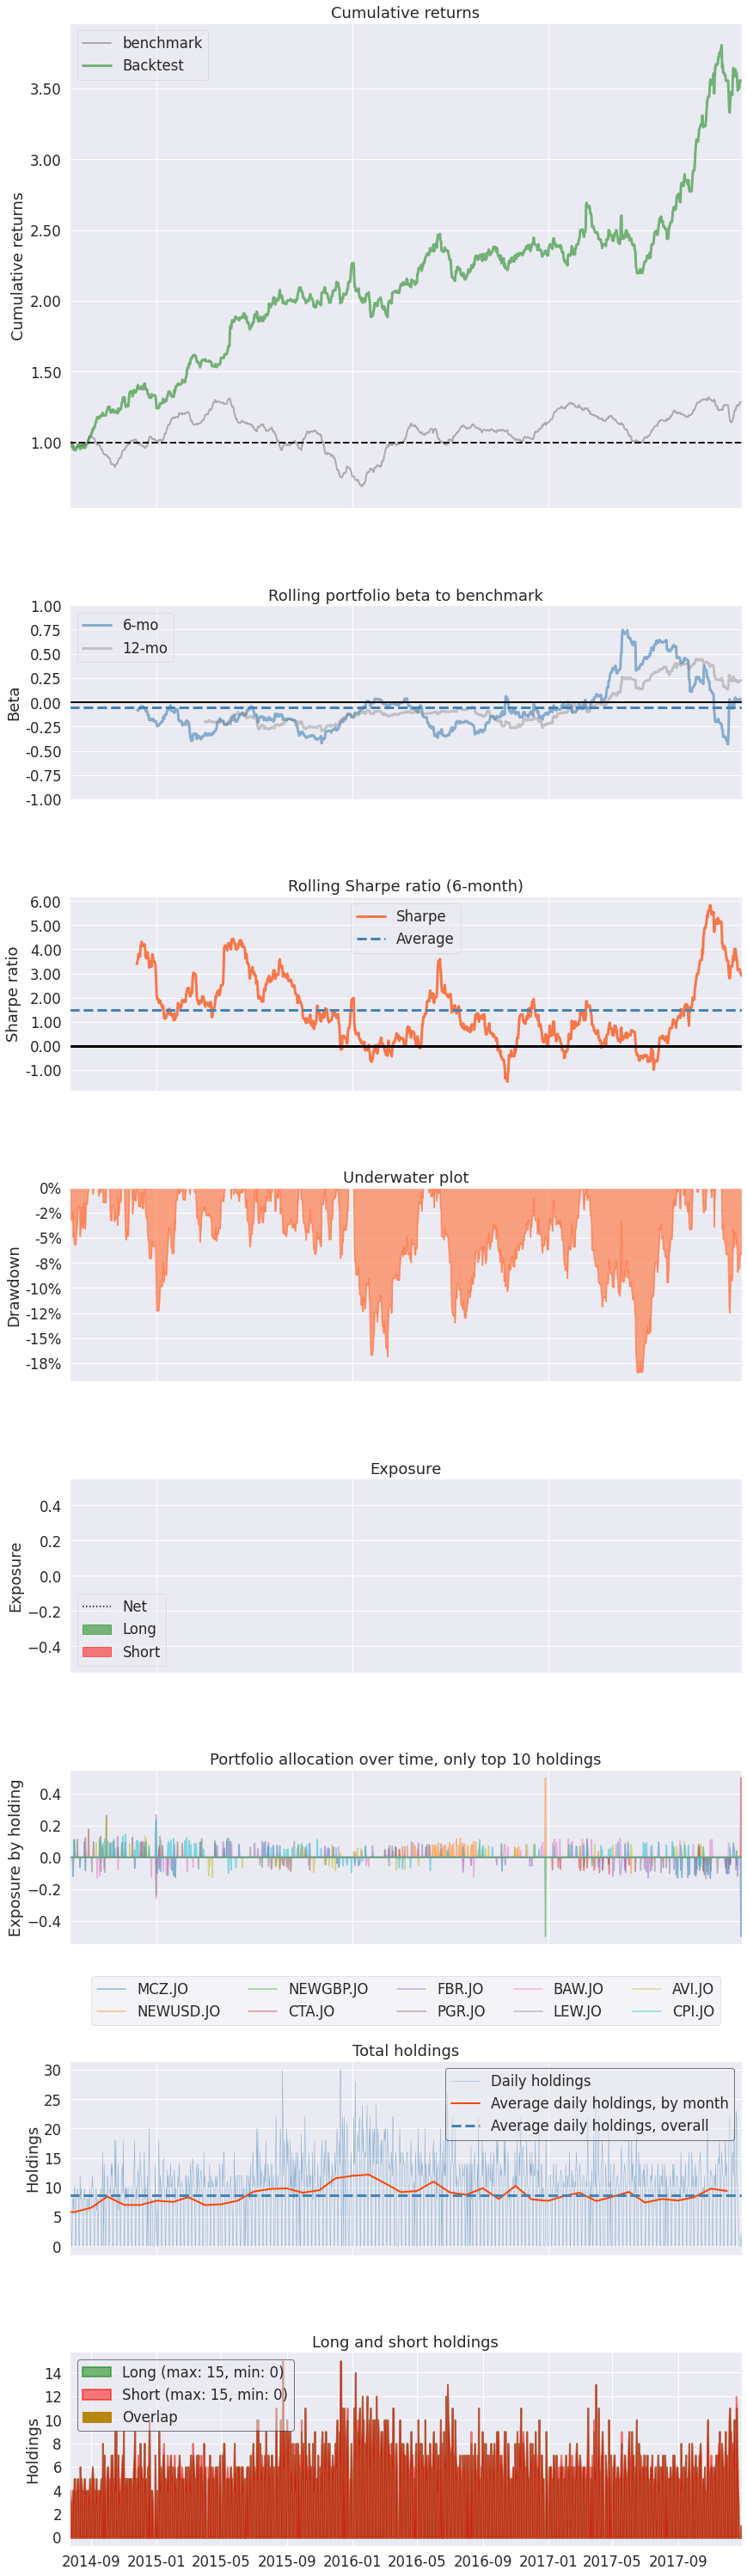

In [176]:
pyfolio.create_simple_tear_sheet(returns, positions, benchmark_rets = benchmark)